# Naive Bayes

In [1]:
import numpy as np
import operator
import functools
from nltk.tokenize import word_tokenize

class NaiveBayes:
    def __init__(self, training_set, labels):
        self.k = len(labels)
        self.labels = labels
        self.prios = np.zeros(self.k)
        words_classes = [ [word_tokenize(training_sentence) for training_sentence in training_text ]
                                                            for training_text in training_set]
        words_classes = []
        for i in range(self.k):
            w_i = [word_tokenize(training_sentence) for training_sentence in training_set[i]]
            words_classes.append(functools.reduce(lambda a,b : a + b, w_i))
            
        training_set_len = sum(sum(len(word) for word in words) for words in words_classes)
        self.likelihood = [{} for _ in range(self.k)]
        for i in range(self.k):
            self.likelihood[i] = {word : (words_classes[i].count(word) + 0.5) 
                                              / (len(words_classes[i]) + 0.5) 
                                              for word in words_classes[i]}
        
        self.priors = [len(words_classes[i]) / training_set_len for i in range(self.k)]
        
    def predict(self, text):
        probabilities = self._get_probabilities(text)
        max_index, max_value = max(enumerate(probabilities), key=operator.itemgetter(1))
        return self.labels[max_index]
    
    def _get_probabilities(self, text):
        words = word_tokenize(text)
        probabilities = []
        for i in range(self.k):
            words_probabilities = [self.likelihood[i][word] if word in self.likelihood[i] 
                                   else np.finfo(np.float32).eps for word in words]
            probabilities.append(functools.reduce(operator.mul, words_probabilities, 1))
        return probabilities
                

#### Feed model with training data
Data used to train and test this data can be found on webpage : https://archive.ics.uci.edu/ml/machine-learning-databases/00331/ 

Model is train based on "yelp_labelled.txt" file and tested based on "amazon_cells_labelled.txt" file.

In [2]:
import pandas as pd

def devide_data(data):
    positive = []
    negative = []
    for sentence, label in zip(data['sentence'], data['label']):
        if label == 1:
            positive.append(sentence)
        else:
            negative.append(sentence)
            
    return (positive, negative)
    
training_data = pd.read_csv('yelp_labelled.txt', sep="\t")
training_data.columns = ["sentence", "label"]
positive, negative = devide_data(training_data)

nb = NaiveBayes([positive, negative], [1, 0])

#### Import testing data & predict

In [3]:
testing_data = pd.read_csv('amazon_cells_labelled.txt', sep="\t")
testing_data.columns = ["sentence", "label"]
predictions_naive_bayes = [ nb.predict(sentence) for sentence in testing_data['sentence']]

Confusion matrix : 
 [[379 120]
 [184 316]]


Text(0.5, 15.0, 'Predicted label')

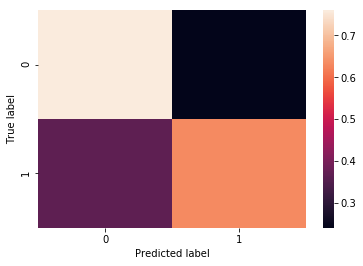

In [13]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_predict
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt


# Generate confusion matrix:
conf_mat=confusion_matrix(testing_data['label'], predictions_naive_bayes)
print("Confusion matrix : \n {}".format(conf_mat))
conf_mat_normalized = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
sns.heatmap(conf_mat_normalized)
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [5]:
# Accuracy 
accuracy = {}
accuracy['naive_bayes'] = accuracy_score(testing_data['label'],predictions_naive_bayes)
print(str(accuracy['naive_bayes']))

0.6956956956956957


In [6]:
# Precision
from sklearn.metrics import precision_score
precision = precision_score(testing_data['label'],predictions_naive_bayes)
print(str(precision))

0.7247706422018348


In [7]:
#Recall score
from sklearn.metrics import recall_score
recall_score = recall_score(testing_data['label'],predictions_naive_bayes)
print(str(recall_score))

0.632


## Compare with other classifier

In [8]:
def prepare_data(data_positive, data_negative, features=None):
    if features is None:
        _features = functools.reduce(lambda a,b : a + b, [data_positive, data_negative])
        features = list(set(functools.reduce(lambda a,b : a + b, _features)))
    
    Y = [1 for _ in range(len(data_positive))] + [0 for _ in range(len(data_negative))]
    sentence_features = [0 for _ in range(len(features))]
    total_len = len(data_positive) + len(data_negative)
    X = [sentence_features for _ in range(total_len)]

    for sentence, i in zip(data_positive + data_negative, range(total_len)):
        words = word_tokenize(sentence)
        words = list(set(words))
        for word in words:
            occurance = words.count(word)
            if word in features:
                index = features.index(word)
                X[i][index] = occurance
                
    return(X,Y, features)
    
    
# prepare training data
training_X, training_Y, features = prepare_data(positive, negative)

# prepare test data
positive_test, negative_test = devide_data(testing_data)
testing_X, testing_Y, features = prepare_data(positive_test, negative_test, features)


#### Multinomial Naive Bayes from sklearn 

In [9]:
from sklearn.naive_bayes import MultinomialNB

snb = MultinomialNB()
snb.fit(training_X, training_Y)

naive_bayes_sklearn_predictions = snb.predict(testing_X)
accuracy['sklearn_naive_bayes'] = accuracy_score(testing_Y, naive_bayes_sklearn_predictions)
print(str(accuracy['sklearn_naive_bayes']))

0.5005005005005005


#### Logistic Regression from sklearn 

In [10]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(training_X, training_Y)
logistic_regression_predictions = model.predict(testing_X)
accuracy['logistic_regression'] = accuracy_score(testing_Y, logistic_regression_predictions)
print(str(accuracy['logistic_regression']))

0.4994994994994995


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


#### K-NN classifier from sklearn

In [11]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=5)
model.fit(training_X, training_Y)
knn_predictions = model.predict(testing_X)
accuracy['k_nn'] = accuracy_score(testing_Y,knn_predictions)
print(str(accuracy['k_nn']))

0.5005005005005005


#### Compare values

In [12]:
best = max(accuracy.items(), key=operator.itemgetter(1))[0]
print("Best accuracy : {} with model : {}  ".format(accuracy[best], best))

Best accuracy : 0.6956956956956957 with model : naive_bayes  


With given data set my custom model of Naive Bayes turn out to be a bit beter the other ones from Sklean library when taking into consideration accuracy.